In [1]:
import csv
import ast

class Player:
    def __init__(self, nick):
        self.nick = nick
        self.elo = 1000
        self.matches_played = 0
        self.wins = 0
        self.losses = 0

    def win_rate(self):
        if self.matches_played == 0:
            return 0
        return self.wins / self.matches_played


players_temp = {}
PLAYERS = []

with open("matches.csv", newline="", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)

    players_unique = set()

    for row in reader:
        players_a = row["a"]
        players_a = ast.literal_eval(players_a)

        players_b = row["b"]
        players_b = ast.literal_eval(players_b)

        for player in players_a:
            players_unique.add(player)

        for player in players_b:
            players_unique.add(player)
        
for player in players_unique:
    players_temp[player] = Player(player)


for player in players_temp:
    PLAYERS.append(players_temp[player])


print(f"{len(PLAYERS)} graczy")

18 graczy


In [2]:
class MatchBasic:
    def __init__(self, match_id, winners, losers, date):
        self.match_id = match_id
        self.winners = winners  # lista playerow
        self.losers = losers    # lista playerow
        self.date = date

class MatchPlayer:
    def __init__(self, match_id, player, elo_change, is_winner):
        self.match_id = match_id
        self.player = player    # ref do Player
        self.elo_change = elo_change
        self.elo_before = 0
        self.elo_after = 0
        self.is_winner = is_winner

class Match(MatchBasic):
    def __init__(self, match_id, winners, losers, date, match_players=None):
        super().__init__(match_id, winners, losers, date)
        self.match_players = match_players or [] 

def get_player_by_nick(nick) -> Player:
    for player in PLAYERS:
        if player.nick == nick:
            return player
        
    print(f"ERROR - Nie znaleziono gracza o nicku {nick}")
    print(len(PLAYERS))
    return None

with open("matches.csv", newline="", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    matches = []

    for row in reader:
        match_id = row["id"]
        winner_team = row["winner"]
        date = row["date"]
        
        def safe_parse_list(s):
            try:
                return ast.literal_eval(s)
            except (ValueError, SyntaxError):
                import re
                matches = re.findall(r"'([^']*)'", s)
                if matches:
                    return matches
                return [s.strip("[]")]
        
        team_a_nicks = safe_parse_list(row["a"])
        team_b_nicks = safe_parse_list(row["b"])
        
        team_a_players = [get_player_by_nick(nick) for nick in team_a_nicks]
        team_b_players = [get_player_by_nick(nick) for nick in team_b_nicks]

        if winner_team == "a":
            winners = team_a_players
            losers = team_b_players
        else:
            winners = team_b_players
            losers = team_a_players
        
        match_players = []

        for player in winners:
            player.matches_played += 1
            player.wins += 1
            match_players.append(MatchPlayer(match_id, player, 0, True))
            
        for player in losers:
            player.matches_played += 1
            player.losses += 1
            match_players.append(MatchPlayer(match_id, player, 0, False))
        
        match = Match(match_id, winners, losers, date, match_players)
        matches.append(match)

for match in matches[:3]:
    winners_nicks = [player.nick for player in match.winners]
    losers_nicks = [player.nick for player in match.losers]
    print(f"{match.match_id}: {winners_nicks} vs {losers_nicks}")
    
    print("  Gracze w meczu:")
    for mp in match.match_players:
        player = mp.player
        status = "Wygrał" if mp.is_winner else "Przegrał"
        print(f"    {player.nick}:\t{status} (W: {player.wins}, L: {player.losses}, M: {player.matches_played})")
    print()

print(f"{len(matches)} meczy")
print(f"{len(PLAYERS)} graczy")

# print("\nNajlepsi gracze (liczba wygranych):")
# top_winners = sorted(PLAYERS, key=lambda p: p.wins, reverse=True)[:10]
# for i, player in enumerate(top_winners, 1):
#     win_rate = round(player.win_rate() * 100, 1) if player.matches_played > 0 else 0
#     print(f"{i}. {player.nick}: {player.wins} wygranych / {player.matches_played} meczów ({win_rate}%)")

67e52aab1b178f6f8300527f: ['suchix'] vs ['filip_pro']
  Gracze w meczu:
    suchix:	Wygrał (W: 98, L: 76, M: 174)
    filip_pro:	Przegrał (W: 56, L: 73, M: 129)

67e528831b178f6f8300527e: ['suchix'] vs ['filip_pro']
  Gracze w meczu:
    suchix:	Wygrał (W: 98, L: 76, M: 174)
    filip_pro:	Przegrał (W: 56, L: 73, M: 129)

67e526af1b178f6f8300527d: ['suchix'] vs ['filip_pro']
  Gracze w meczu:
    suchix:	Wygrał (W: 98, L: 76, M: 174)
    filip_pro:	Przegrał (W: 56, L: 73, M: 129)

291 meczy
18 graczy


In [3]:
def calculate_elo_ratings(matches, K_SOLO=38, K_TEAM=24):
    def expected_score(rating_a, rating_b):
        return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    
    def calculate_new_rating(old_rating, expected, actual, k_factor):
        return old_rating + k_factor * (actual - expected)
        
    for match in matches:
        for mp in match.match_players:
            mp.elo_before = mp.player.elo
            
        is_team_match = len(match.winners) > 1 or len(match.losers) > 1
        k_factor = K_TEAM if is_team_match else K_SOLO
        
        winners_avg_elo = sum(player.elo for player in match.winners) / len(match.winners)
        losers_avg_elo = sum(player.elo for player in match.losers) / len(match.losers)
        
        winners_expected = expected_score(winners_avg_elo, losers_avg_elo)
        losers_expected = 1 - winners_expected
        
        team_size_factor = 1.0
        if is_team_match:
            team_size = max(len(match.winners), len(match.losers))
            team_size_factor = 1.0 / (1 + 0.1 * (team_size - 2))  

        adjusted_k = k_factor * team_size_factor
        
        for mp in match.match_players:
            if mp.is_winner:
                old_elo = mp.player.elo
                new_elo = calculate_new_rating(old_elo, winners_expected, 1.0, adjusted_k)
                elo_change = new_elo - old_elo
            else:
                old_elo = mp.player.elo
                new_elo = calculate_new_rating(old_elo, losers_expected, 0.0, adjusted_k)
                elo_change = new_elo - old_elo
            
            mp.elo_change = round(elo_change, 1)
            mp.player.elo = round(new_elo, 1)
    
    return matches

matches = matches[::-1]

calculated_matches = calculate_elo_ratings(matches)

sorted_players = sorted(PLAYERS, key=lambda p: p.elo, reverse=True)
print("\nTopka:")
for i, player in enumerate(sorted_players):
    print(f"{i+1}. {player.nick}: {player.elo} ({player.wins}/{player.matches_played} matches)")


Topka:
1. suchix: 1112.7 (98/174 matches)
2. michal: 1071.7 (27/42 matches)
3. rafał radosław malczyk: 1067.9 (27/42 matches)
4. remzak: 1063.6 (58/120 matches)
5. karol: 1035.1 (17/29 matches)
6. Filip Rusztowicz: 1029.2 (25/40 matches)
7. TenOdHighGrounda: 1024.9 (2/3 matches)
8. kb316244: 1021.9 (4/5 matches)
9. egzorcysta: 1012.0 (3/5 matches)
10. tirstus: 1009.3 (3/5 matches)
11. ż: 1002.3 (1/3 matches)
12. kondrix: 976.2 (10/21 matches)
13. jacek: 964.8 (0/2 matches)
14. topol: 951.2 (18/39 matches)
15. filip_pro: 950.8 (56/129 matches)
16. marta: 911.3 (12/39 matches)
17. oskarito: 909.0 (32/79 matches)
18. piloniak: 886.1 (9/27 matches)


In [4]:
print("\nHistoria meczów (od najstarszego do najnowszego):")
for match in matches:
    winners_str = ", ".join(p.nick for p in match.winners)
    losers_str = ", ".join(p.nick for p in match.losers)
    match_date = match.date[:10] # tylko data, bez czasu
    print(f"\nMecz {match_date}: {winners_str} vs {losers_str}")
    
    print("Zwycięzcy:")
    for mp in [mp for mp in match.match_players if mp.is_winner]:
        print(f"  {mp.player.nick}: {mp.elo_before} -> {mp.elo_before + mp.elo_change} (+{mp.elo_change})")
    
    print("Przegrani:")
    for mp in [mp for mp in match.match_players if not mp.is_winner]:
        print(f"  {mp.player.nick}: {mp.elo_before} -> {mp.elo_before + mp.elo_change} ({mp.elo_change})")


Historia meczów (od najstarszego do najnowszego):

Mecz 2024-12-10: remzak vs suchix
Zwycięzcy:
  remzak: 1000 -> 1019.0 (+19.0)
Przegrani:
  suchix: 1000 -> 981.0 (-19.0)

Mecz 2024-12-10: remzak vs suchix
Zwycięzcy:
  remzak: 1019.0 -> 1035.9 (+16.9)
Przegrani:
  suchix: 981.0 -> 964.1 (-16.9)

Mecz 2024-12-10: suchix vs remzak
Zwycięzcy:
  suchix: 964.1 -> 987.0 (+22.9)
Przegrani:
  remzak: 1035.9 -> 1013.0000000000001 (-22.9)

Mecz 2024-12-10: filip_pro vs remzak
Zwycięzcy:
  filip_pro: 1000 -> 1019.7 (+19.7)
Przegrani:
  remzak: 1013.0 -> 993.3 (-19.7)

Mecz 2024-12-10: filip_pro vs remzak
Zwycięzcy:
  filip_pro: 1019.7 -> 1037.3 (+17.6)
Przegrani:
  remzak: 993.3 -> 975.6999999999999 (-17.6)

Mecz 2024-12-10: filip_pro vs remzak
Zwycięzcy:
  filip_pro: 1037.3 -> 1053.0 (+15.7)
Przegrani:
  remzak: 975.7 -> 960.0 (-15.7)

Mecz 2024-12-10: remzak vs filip_pro
Zwycięzcy:
  remzak: 960.0 -> 984.0 (+24.0)
Przegrani:
  filip_pro: 1053.0 -> 1029.0 (-24.0)

Mecz 2024-12-11: suchix vs to

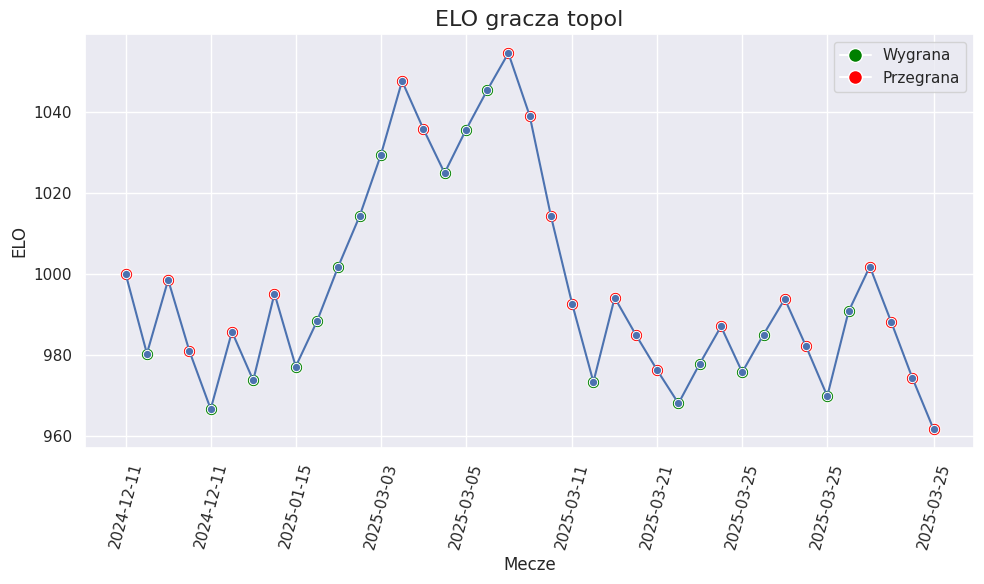

In [ ]:
# support class for graphing
class PlayerStatsInTime(Player):
    def __init__(self, elo, date, result=None):
        self.elo = elo
        self.date = date
        self.result = result

def get_player_stats_in_time(player):
    stats = []
    for match in matches:
        for mp in match.match_players:
            if mp.player == player:
                stats.append(PlayerStatsInTime(mp.elo_before, match.date, 
                                             "Win" if mp.is_winner else "Loss"))
    return stats

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from matplotlib.lines import Line2D

sns.set_theme(style="darkgrid")

# FOR PLAYER:
player = get_player_by_nick("suchix")
stats = get_player_stats_in_time(player)

data = {
    'date': [datetime.strptime(s.date, "%Y-%m-%d %H:%M:%S") for s in stats],
    'elo': [s.elo for s in stats],
    'result': [s.result for s in stats]
}
df = pd.DataFrame(data)
df = df.sort_values('date')

df['match_num'] = range(len(df))

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='match_num', y='elo', marker='o')

sns.scatterplot(data=df[df['result'] == 'Win'], x='match_num', y='elo', color='green', s=80)
sns.scatterplot(data=df[df['result'] == 'Loss'], x='match_num', y='elo', color='red', s=80)

num_ticks = min(10, len(df))
tick_indices = [int(i * (len(df)-1) / (num_ticks-1)) for i in range(num_ticks)] if num_ticks > 1 else [0]
tick_labels = [df.iloc[i]['date'].strftime('%Y-%m-%d') for i in tick_indices]

plt.xticks(tick_indices, tick_labels, rotation=75)

plt.title(f"ELO gracza {player.nick}", fontsize=16)
plt.xlabel("Mecze", fontsize=12)
plt.ylabel("ELO", fontsize=12)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Wygrana'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Przegrana')
]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# todo
- moze jakis smieszny wykresik do tego jeszcze dorzucic, na zmitacu i tutaj

# pomysły

customowe K dla dni tygodnia?
+jakis bonus dla dnia tygodnia w ktorym najrzadziej sie gra

cos trzeba wymyslec hehe